In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.path.abspath('..'),
                  os.pardir)
)
numericalExperimentsPath = os.path.abspath('..')

sys.path.append(PROJECT_ROOT)

from electronTransportCode.MCEstimator import DoseEstimator, TrackPosition
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron
from electronTransportCode.MCParticleTracer import KDMC, AnalogParticleTracer
from lungSetup import LungInitialConditions, LungSimulationDomain, I_BONE
from electronTransportCode.ProjectUtils import E_THRESHOLD, ERE

%matplotlib widget

In [2]:
# Load particle, initial conditions and simulation domain
bins = 200; width = 10; SEED = 10
particle = SimplifiedEGSnrcElectron(scatterer="3d")
lungInit = LungInitialConditions(width=width, rngSeed=SEED)
lungSimDomain = LungSimulationDomain(bins=bins, width=width)
_, step = np.linspace(0, width, bins+1, retstep=True)

# Load particle tracers
analogTracer = AnalogParticleTracer(simOptions=lungInit, simDomain=lungSimDomain, particle=particle)
kdmc = KDMC(simOptions=lungInit, simDomain=lungSimDomain, particle=particle, dS=step/2)  # type: ignore
posTrackerK = TrackPosition(lungSimDomain)
posTrackerKD = TrackPosition(lungSimDomain)
doseEstimatorK = DoseEstimator(lungSimDomain)
doseEstimatorKD = DoseEstimator(lungSimDomain)

In [3]:
NB_PARTICLES = 1
analogTracer(NB_PARTICLES, (doseEstimatorK, posTrackerK))

(<electronTransportCode.MCEstimator.DoseEstimator at 0x7fc5d5aae170>,
 <electronTransportCode.MCEstimator.TrackPosition at 0x7fc5d5aadff0>)

In [4]:
kdmc(NB_PARTICLES, (doseEstimatorKD, posTrackerKD))

(<electronTransportCode.MCEstimator.DoseEstimator at 0x7fc5d5aae140>,
 <electronTransportCode.MCEstimator.TrackPosition at 0x7fc5dc31fcd0>)

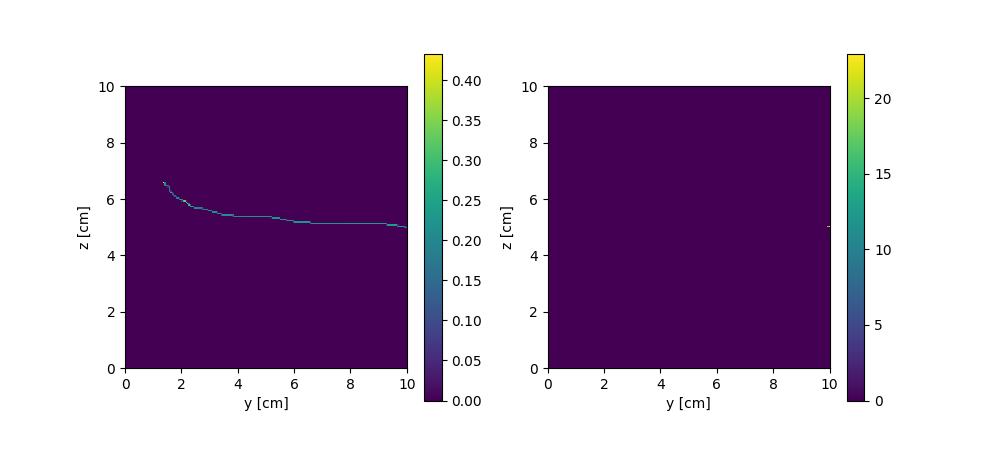

In [5]:
# Plot energy deposition in a subdomain
startIndex = 0; endIndex = bins+1
xBins = np.linspace(0, width, bins+1)
x = xBins[startIndex:endIndex]
nticks = 6

energyDepositionK_ERE = np.reshape(doseEstimatorK.scoreMatrix, (bins, bins) )
energyDepositionK_ERE = np.flipud(energyDepositionK_ERE[startIndex:endIndex,startIndex:endIndex])
energyDepositionKD_ERE = np.reshape(doseEstimatorKD.scoreMatrix, (bins, bins) )
energyDepositionKD_ERE = np.flipud(energyDepositionKD_ERE[startIndex:endIndex,startIndex:endIndex])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))

pox = ax1.matshow(energyDepositionK_ERE, extent=[x.min(), x.max(), x.min(), x.max()])
ax1.set_xticks(np.linspace(x.min(), x.max(), nticks))
ax1.set_yticks(np.linspace(x.min(), x.max(), nticks))
ax1.xaxis.tick_bottom()
ax1.set_xlabel('y [cm]')
ax1.set_ylabel('z [cm]')
fig.colorbar(pox, ax=ax1)

pox = ax2.matshow(energyDepositionKD_ERE, extent=[x.min(), x.max(), x.min(), x.max()])
ax2.set_xticks(np.linspace(x.min(), x.max(), nticks))
ax2.set_yticks(np.linspace(x.min(), x.max(), nticks))
ax2.xaxis.tick_bottom()
ax2.set_xlabel('y [cm]')
ax2.set_ylabel('z [cm]')
fig.colorbar(pox, ax=ax2)

(-10.0, 0.0)

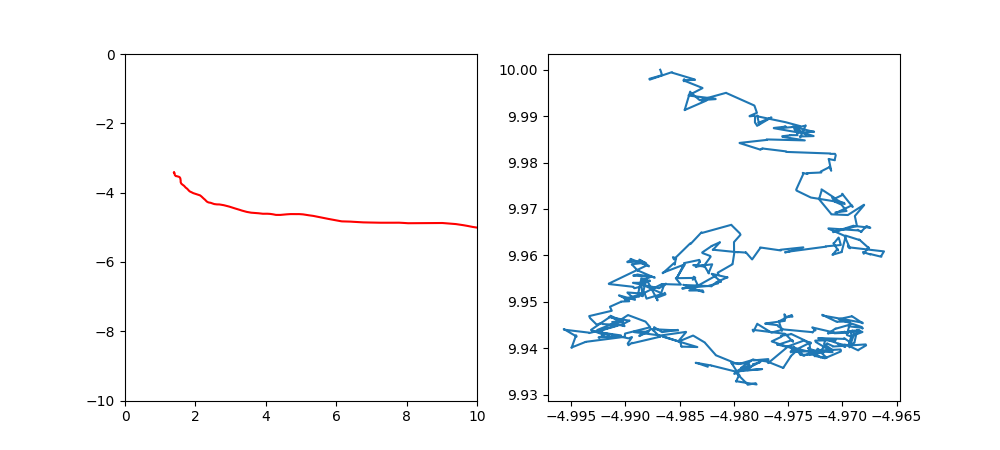

In [6]:
zk = posTrackerK.scoreMatrix[0:posTrackerK.index, 2]
yk = posTrackerK.scoreMatrix[0:posTrackerK.index, 1]
zkd = posTrackerKD.scoreMatrix[0:posTrackerKD.index, 2]
ykd = posTrackerKD.scoreMatrix[0:posTrackerKD.index, 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
ax2.plot(zkd, ykd)
ax1.plot(yk, zk, c='r')
ax1.set_xlim([0, 10])
ax1.set_ylim([-10, 0])
# ax1.set_xlim(ax2.get_xlim())
# ax1.set_ylim(ax2.get_ylim())

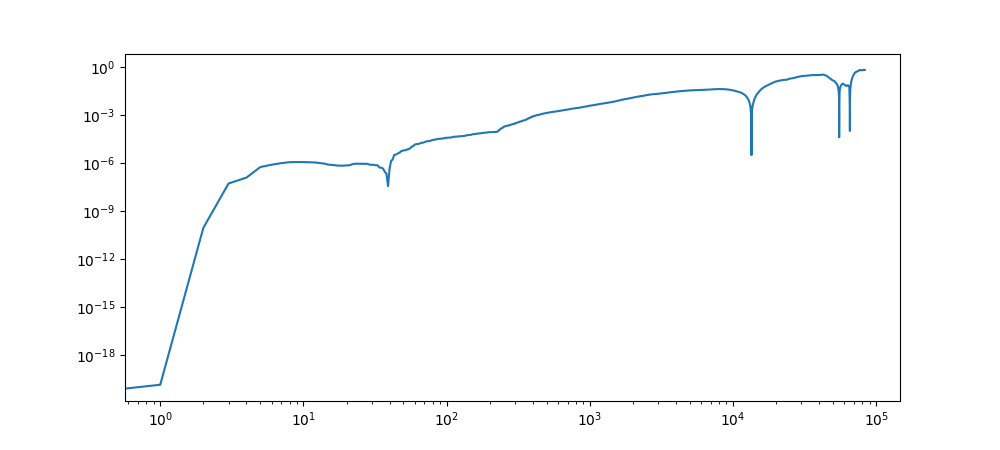

In [10]:
# Even though 2D scattering is on, rounding errors accumulate in the x-coordinate
xk = posTrackerK.scoreMatrix[0:posTrackerK.index, 0]
fig, ax1 = plt.subplots(figsize=(10, 4.5))
ax1.loglog(abs(xk))